## Does not make sense

Cannot be finetuned with all 4 losses. The term 1 and term 4 are contradictory.

In [1]:
import numpy as np
import pandas as pd
import random

import torch
import torch.nn as nn
import torch.nn.functional as F

import seaborn as sns
import matplotlib.pyplot as plt
import os

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from collections import OrderedDict
from tqdm import tqdm

import warnings
warnings.filterwarnings("ignore")

In [2]:
# CUDA support 
if torch.cuda.is_available():
    device = torch.device('cuda:5')
else:
    device = torch.device('cpu')
    
print(device)
device = torch.device('cpu')

cpu


In [3]:
# the deep neural network
class MLP(torch.nn.Module):
    def __init__(self, layers, activation="relu", init="xavier"):
        super(MLP, self).__init__()
        
        # parameters
        self.depth = len(layers) - 1
        
        if activation == "relu":
            self.activation = torch.nn.ReLU()
        elif activation == "tanh":
            self.activation = torch.nn.Tanh()
        elif activation == "gelu":
            self.activation = torch.nn.GELU()
        else:
            raise ValueError("Unspecified activation type")
        
        
        layer_list = list()
        for i in range(self.depth - 1): 
            layer_list.append(
                ('layer_%d' % i, torch.nn.Linear(layers[i], layers[i+1]))
            )
            layer_list.append(('activation_%d' % i, self.activation))
            
        layer_list.append(
            ('layer_%d' % (self.depth - 1), torch.nn.Linear(layers[-2], layers[-1]))
        )
        layerDict = OrderedDict(layer_list)
        
        # deploy layers
        self.layers = torch.nn.Sequential(layerDict)

        if init=="xavier":
            self.xavier_init_weights()
        elif init=="kaiming":
            self.kaiming_init_weights()
    
    def xavier_init_weights(self):
        with torch.no_grad():
            print("Initializing Network with Xavier Initialization..")
            for m in self.layers.modules():
                if hasattr(m, 'weight'):
                    nn.init.xavier_uniform_(m.weight)
                    m.bias.data.fill_(0.0)

    def kaiming_init_weights(self):
        with torch.no_grad():
            print("Initializing Network with Kaiming Initialization..")
            for m in self.layers.modules():
                if hasattr(m, 'weight'):
                    nn.init.kaiming_uniform_(m.weight)
                    m.bias.data.fill_(0.0)
                        
    def forward(self, x):
        out = self.layers(x)
        return out
    
class DataGenerator(torch.utils.data.Dataset):
    def __init__(self, X):
        self.X = X
        
    def __getitem__(self, index):
        return self.X[index]
    
    def __len__(self):
        return len(self.X)

In [4]:
data_df = pd.read_csv("./../02_training/all_data_lake_modeling_in_time.csv")
time = data_df['time']
data_df = data_df.drop(columns=['time'])
data_df
display(data_df.head)

<bound method NDFrame.head of         depth  AirTemp_degC  Longwave_Wm-2  Latent_Wm-2  Sensible_Wm-2  \
0           1     13.965021     717.887954   -32.080993      -6.880394   
1           2     13.965021     717.887954   -32.080993      -6.880394   
2           3     13.965021     717.887954   -32.080993      -6.880394   
3           4     13.965021     717.887954   -32.080993      -6.880394   
4           5     13.965021     717.887954   -32.080993      -6.880394   
...       ...           ...            ...          ...            ...   
495570     21     17.945001     796.182785   -59.448422     -13.843945   
495571     22     17.945001     796.182785   -59.448422     -13.843945   
495572     23     17.945001     796.182785   -59.448422     -13.843945   
495573     24     17.945001     796.182785   -59.448422     -13.843945   
495574     25     17.945001     796.182785   -59.448422     -13.843945   

        Shortwave_Wm-2  lightExtinct_m-1  ShearVelocity_mS-1  \
0                

In [5]:
training_frac = 0.60
depth_steps = 25
number_days = len(data_df)//depth_steps
n_obs = int(number_days*training_frac)*depth_steps
print(f"Number of days total: {number_days}")
print(f"Number of training points: {n_obs}")

Number of days total: 19823
Number of training points: 297325


# Normalizing Data

In [6]:
data = data_df.values

train_data = data[:n_obs]
test_data = data[n_obs:]

train_time = time[:n_obs]
test_time = time[n_obs:]

#performing normalization on all the columns
scaler = StandardScaler()
scaler.fit(train_data)
train_data = scaler.transform(train_data)
test_data = scaler.transform(test_data)

In [7]:
m0_output_column_ix = [data_df.columns.get_loc(column) for column in ['temp_heat01']]

# Loading Models

In [8]:
m0_input_columns = ['depth', 'AirTemp_degC', 'Longwave_Wm-2', 'Latent_Wm-2', 'Sensible_Wm-2', 'Shortwave_Wm-2',
                'lightExtinct_m-1','Area_m2', 
                 'day_of_year', 'time_of_day', 'temp_initial00']
m0_output_columns = ['temp_heat01']

m0_input_column_ix = [data_df.columns.get_loc(column) for column in m0_input_columns]
m0_output_column_ix = [data_df.columns.get_loc(column) for column in m0_output_columns]

m0_PATH =  f"./../02_training/saved_models/heating_model_time.pth"
m0_layers = [len(m0_input_columns), 32, 32, len(m0_output_columns)]

heating_model = MLP(m0_layers, activation="gelu")
m0_checkpoint = torch.load(m0_PATH, map_location=torch.device('cpu'))
heating_model.load_state_dict(m0_checkpoint)
heating_model = heating_model.to(device)

Initializing Network with Xavier Initialization..


## Heat Diffusion Model

In [9]:
m1_input_columns = ['depth', 'AirTemp_degC', 'Longwave_Wm-2', 'Latent_Wm-2', 'Sensible_Wm-2', 'Shortwave_Wm-2',
                'lightExtinct_m-1', 'ShearVelocity_mS-1', 'ShearStress_Nm-2', 'Area_m2', 
                 'buoyancy', 'day_of_year', 'time_of_day', 'diffusivity', 'temp_heat01']
m1_output_columns = ['temp_diff02']

m1_input_column_ix = [data_df.columns.get_loc(column) for column in m1_input_columns]
m1_output_column_ix = [data_df.columns.get_loc(column) for column in m1_output_columns]

m1_PATH = f"./../02_training/saved_models/heat_diffusion_model_time.pth"
m1_layers = [len(m1_input_columns), 32, 32, len(m1_output_columns)]

heat_diff_model = MLP(m1_layers, activation="gelu")
m1_checkpoint = torch.load(m1_PATH, map_location=torch.device('cpu'))
heat_diff_model.load_state_dict(m1_checkpoint)
heat_diff_model = heat_diff_model.to(device)

Initializing Network with Xavier Initialization..


## Mixing Model

In [10]:
m2_input_columns = ['depth', 'ShearVelocity_mS-1', 'ShearStress_Nm-2', 'day_of_year', 'time_of_day', 'temp_diff02']
m2_output_columns = ['temp_mix03']

m2_input_column_ix = [data_df.columns.get_loc(column) for column in m2_input_columns]
m2_output_column_ix = [data_df.columns.get_loc(column) for column in m2_output_columns]

m2_PATH = f"./../02_training/saved_models/mixing_model_time.pth"
m2_layers = [len(m2_input_columns), 32, 32, len(m2_output_columns)]

mixing_model = MLP(m2_layers, activation="gelu")
m2_checkpoint = torch.load(m2_PATH, map_location=torch.device('cpu'))
mixing_model.load_state_dict(m2_checkpoint)
mixing_model = mixing_model.to(device)

Initializing Network with Xavier Initialization..


# Convection Model

In [11]:
m3_input_columns = ['depth', 'day_of_year', 'time_of_day', 'temp_mix03']
m3_output_columns = ['temp_conv04']

m3_input_column_ix = [data_df.columns.get_loc(column) for column in m3_input_columns]
m3_output_column_ix = [data_df.columns.get_loc(column) for column in m3_output_columns]

m3_PATH = f"./../02_training/saved_models/convection_model_time.pth"
m3_layers = [len(m3_input_columns), 32, 32, len(m3_output_columns)]

convection_model = MLP(m3_layers, activation="gelu")
m3_checkpoint = torch.load(m3_PATH, map_location=torch.device('cpu'))
convection_model.load_state_dict(m3_checkpoint)
convection_model = convection_model.to(device)

Initializing Network with Xavier Initialization..


# Ice Model

In [12]:
m4_input_columns = ['depth', 'day_of_year', 'time_of_day', 'temp_conv04']
m4_output_columns = ['temp_total05']

m4_input_column_ix = [data_df.columns.get_loc(column) for column in m4_input_columns]
m4_output_column_ix = [data_df.columns.get_loc(column) for column in m4_output_columns]

m4_PATH = f"./../02_training/saved_models/ice_model_time.pth"
m4_layers = [len(m4_input_columns), 32, 32, len(m4_output_columns)]

ice_model = MLP(m4_layers, activation="gelu")
m4_checkpoint = torch.load(m4_PATH, map_location=torch.device('cpu'))
ice_model.load_state_dict(m4_checkpoint)
ice_model = ice_model.to(device)

Initializing Network with Xavier Initialization..


In [13]:
obs_temp_columns = ['obs_temp']

obs_temp_columns_ix = [data_df.columns.get_loc(column) for column in obs_temp_columns]

In [14]:
# depth_steps = 24
# train_data = np.reshape(train_data, (train_data.shape[0]//depth_steps, depth_steps, train_data.shape[1]))
# test_data = np.reshape(test_data, (test_data.shape[0]//depth_steps, depth_steps, test_data.shape[1]))

In [15]:
#keeping track of the mean and standard deviations
train_mean = scaler.mean_
train_std = scaler.scale_

In [16]:
# Create data set
batch_size = 1000

assert batch_size % 25 ==0, "Batchsize has to be multiple of 25" 

train_dataset = DataGenerator(train_data)
test_dataset = DataGenerator(test_data)
# train_dataset = torch.utils.data.TensorDataset(X_train, y_train)
# test_dataset = torch.utils.data.TensorDataset(X_test, y_test)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, 
                                           shuffle=False)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size,
                                          shuffle=False)

In [17]:
print(train_data.shape)
print(test_data.shape)

(297325, 23)
(198250, 23)


In [18]:
def rmse(true, pred):
    return (((true-pred)**2).mean()**0.5).detach().cpu().numpy()

def l2_error(true, pred):
    return np.linalg.norm(pred.detach().cpu().numpy() - true.detach().cpu().numpy()) / np.linalg.norm(true.detach().cpu().numpy()) 

In [19]:
#keeping track of the mean and standard deviations

input_mean, input_std = train_mean[m1_input_column_ix], train_std[m1_input_column_ix]
output_mean, output_std = train_mean[m1_output_column_ix], train_std[m1_output_column_ix]

mean_diff = torch.tensor(input_mean[m1_input_column_ix[13]]).to(device)
std_diff = torch.tensor(input_std[m1_input_column_ix[13]]).to(device)

mean_temp = torch.tensor(input_mean[m1_input_column_ix[14]]).to(device)
std_temp = torch.tensor(input_std[m1_input_column_ix[14]]).to(device)

mean_out = torch.tensor(output_mean).to(device)
std_out = torch.tensor(output_std).to(device)
    
def implicit_diffusion(diff, temp, dt=3600, dx=1, depth_steps=25):
    # de-normalise data
    diff = diff * std_diff + mean_diff
    diff = diff.view(-1, depth_steps)
    
    # INPUT DATA FROM PREVIOUS MODULE
    t = temp * std_temp + mean_temp # temperature profile from previous module output
    t = t.view(-1, depth_steps)
    
    # IMPLEMENTATION OF CRANK-NICHOLSON SCHEME
#     len_t = t.shape[1]
    y = torch.zeros((t.shape[0], depth_steps, depth_steps), dtype=torch.float64).to(device)

    alpha = (dt/dx**2) * diff

    az = - alpha # subdiagonal
    bz = 2 * (1 + alpha) # diagonal
    cz = - alpha # superdiagonal
    
    bz[:, 0] = 1
    az[:, depth_steps-2] = 0
    bz[:, depth_steps-1] = 1
    cz[:, 0] = 0
    
    az = az[:,1:]
    cz = cz[:,:-1]

    y = torch.diag_embed(bz, offset=0)+torch.diag_embed(az,offset=-1)+torch.diag_embed(cz,offset=1) #slightly efficient way of computing the diagonal matrices
    y[:, depth_steps-1, depth_steps-1] = 1
    
    mn = torch.zeros_like(t)  
    mn[:, 0] = t[:, 0]
    mn[:,depth_steps-1] = t[:, depth_steps-1]
    
    mn[:, 1:depth_steps-1] = alpha[:, 1:depth_steps-1]*t[:, :depth_steps-2] + 2 * (1 - alpha[:,1:depth_steps-1])*t[:,1:depth_steps-1] + alpha[:,1:depth_steps-1]*t[:,1:depth_steps-1] #is be same as the loop
    
    # DERIVED TEMPERATURE OUTPUT FOR NEXT MODULE
    proj = torch.linalg.solve(y, mn)

    mean, std, var = torch.mean(proj), torch.std(proj), torch.var(proj)
    proj = (proj-mean_out)/std_out

    proj = proj.to(torch.float32)
    proj = proj.view(-1, 1)
    return proj

In [20]:
def compute_metrics(model, loader, input_columns, output_columns, train_mean, train_std):
    model.eval()
    y_ = []
    pred_ = []
    mean = torch.tensor(train_mean[output_columns]).to(device)
    std = torch.tensor(train_std[output_columns]).to(device)
    
    for x in iter(loader):
        inputs, target = x[:, input_columns].to(device).float(), x[:, output_columns].to(device).float()
        pred = model(inputs)
        target = target * std + mean
        pred = pred * std + mean
        y_.append(target)
        pred_.append(pred)
    y_ = torch.cat(y_, dim=0) 
    pred_ = torch.cat(pred_, dim=0)
    
    if y_.shape[1]==2:
        rmse_temp = rmse(y_[:,1], pred_[:,1])
        l2_error_temp = l2_error(y_[:,1], pred_[:,1])
    else:
        rmse_temp = rmse(y_[:,0], pred_[:,0])
        l2_error_temp = l2_error(y_[:,0], pred_[:,0])
        
    return rmse_temp, l2_error_temp

In [21]:
print(m1_input_column_ix)
print(m1_input_column_ix[:-1])
print(m1_input_column_ix[:-2])
print(m1_input_column_ix[14])

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 12, 16, 17, 13, 14]
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 12, 16, 17, 13]
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 12, 16, 17]
14


In [22]:
def get_rollout_predictions(heating_model, heat_diff_model, mixing_model, convection_model, ice_model, loader, plot = True):    
    heating_model.eval()
    heat_diff_model.eval()
    mixing_model.eval()
    convection_model.eval()
    ice_model.eval()

    mean = torch.tensor(train_mean[m4_output_column_ix]).float().to(device)
    std = torch.tensor(train_std[m4_output_column_ix]).float().to(device)

    m1_mean = torch.tensor(train_mean[m1_input_column_ix[-1]]).float().to(device)
    m1_std = torch.tensor(train_std[m1_input_column_ix[-1]]).float().to(device)

#     depthwise_y_pred = []
#     depthwise_y_true = []
    y_ = []
    y_obs_ = []
    pred_ = []
        
    rmse_models = np.zeros((len(loader), 5))
    for ix, x in enumerate(iter(loader)):
        x = x.to(device).float()
        
        m0_input = x[:, m0_input_column_ix]
            
        #model 0
        m0_pred = heating_model(m0_input) #predicts diff and temp
            
        if plot:
            m0_y_true = x[:, m0_output_column_ix[0]] * torch.tensor(train_std[m0_output_column_ix[0]]).to(device) + torch.tensor(train_mean[m0_output_column_ix[0]]).to(device)
            m0_y_pred = m0_pred * torch.tensor(train_std[m0_output_column_ix[0]]).to(device) + torch.tensor(train_mean[m0_output_column_ix[0]]).to(device)
#             print(m1_y_true.shape, m1_y_pred.shape)
#             print("True",m1_y_true)
#             print("Pred",m1_y_pred)
            rmse_models[ix, 0] = rmse(m0_y_true.squeeze(), m0_y_pred.squeeze())
#             print(x[:, m1_output_column_ix[1]])
#             print(m1_pred_temp)
#             print(criterion(m1_pred_temp, x[:, m1_output_column_ix[1]]))
            print("RMSE of after m0", rmse(m0_y_true.flatten(), m0_y_pred.flatten()))

        #model 2
        m1_input = torch.cat([x[:, m1_input_column_ix[:-1]], m0_pred], dim=-1)
        #m1_input = x[:, m1_input_column_ix]
            
        #model 1
        # m1_pred = heat_diff_model(m1_input) #predicts diff and temp
        
        temp_input = m0_y_pred = m0_pred * torch.tensor(train_std[m0_output_column_ix[0]]).to(device) + torch.tensor(train_mean[m0_output_column_ix[0]]).to(device)
       # print(temp_input)
        
        proj = heat_diff_model(m1_input)
        
        pred = implicit_diffusion(proj, m0_pred)        
        m1_pred = pred.to(dtype=torch.float32)
        
        #print(m1_pred)
        
        if plot:
            m1_y_true = x[:, m1_output_column_ix[0]] * torch.tensor(train_std[m1_output_column_ix[0]]).to(device) + torch.tensor(train_mean[m1_output_column_ix[0]]).to(device)
            m1_y_pred = m1_pred * torch.tensor(train_std[m1_output_column_ix[0]]).to(device) + torch.tensor(train_mean[m1_output_column_ix[0]]).to(device)
#             print(m1_y_true.shape, m1_y_pred.shape)
#             print("True",m1_y_true)
#             print("Pred",m1_y_pred)
            rmse_models[ix, 1] = rmse(m1_y_true.squeeze(), m1_y_pred.squeeze())
#             print(x[:, m1_output_column_ix[1]])
#             print(m1_pred_temp)
#             print(criterion(m1_pred_temp, x[:, m1_output_column_ix[1]]))
            print("RMSE of after m1", rmse(m1_y_true.flatten(), m1_y_pred.flatten()))

        #model 2
        m2_input = torch.cat([x[:, m2_input_column_ix[:-1]], m1_pred], dim=-1)
        m2_pred = mixing_model(m2_input)
            
        if plot:
            m2_y_true = x[:, m2_output_column_ix] * torch.tensor(train_std[m2_output_column_ix[0]]).to(device) + torch.tensor(train_mean[m2_output_column_ix[0]]).to(device)
            m2_y_pred = m2_pred * torch.tensor(train_std[m2_output_column_ix[0]]).to(device) + torch.tensor(train_mean[m2_output_column_ix[0]]).to(device)
            rmse_models[ix, 2] = rmse(m2_y_true.squeeze(), m2_y_pred.squeeze())
            print("RMSE of after m2", rmse(m2_y_true.flatten(), m2_y_pred.flatten()))

        #model 3
        m3_input = torch.cat([x[:, m3_input_column_ix[:-1]], m2_pred], dim=-1)
        m3_pred = convection_model(m3_input)
            
        if plot:
            m3_y_true = x[:, m3_output_column_ix] * torch.tensor(train_std[m3_output_column_ix[0]]).to(device) + torch.tensor(train_mean[m3_output_column_ix[0]]).to(device)
            m3_y_pred = m3_pred * torch.tensor(train_std[m3_output_column_ix[0]]).to(device) + torch.tensor(train_mean[m3_output_column_ix[0]]).to(device)
            rmse_models[ix, 3] = rmse(m3_y_true.squeeze(), m3_y_pred.squeeze())
            print("RMSE of after m3", rmse(m3_y_true.flatten(), m3_y_pred.flatten()))

        #model 4
        m4_input = torch.cat([x[:, m4_input_column_ix[:-1]], m3_pred], dim=-1)
        m4_pred = ice_model(m4_input)
            
        if plot:
            m4_y_true = x[:, m4_output_column_ix] * std + mean
            m4_y_pred = m4_pred * std + mean
            rmse_models[ix, 4] = rmse(m4_y_true.squeeze(), m4_y_pred.squeeze())
            print("RMSE of after m4", rmse(m4_y_true.flatten(), m4_y_pred.flatten()))

        y_true = x[:, m4_output_column_ix] * std + mean
        y_obs = x[:, obs_temp_columns_ix] * train_std[obs_temp_columns_ix[0]] + train_mean[obs_temp_columns_ix[0]]
        pred = m4_pred * std + mean
        
        y_.append(y_true)
        y_obs_.append(y_obs)
        pred_.append(pred)

    y_ = torch.cat(y_, dim=0)
    y_obs_ = torch.cat(y_obs_, dim=0)
    pred_ = torch.cat(pred_, dim=0) 
    
    #if plot:   
     #        rmse_models = rmse_models.mean(axis=0)
     #        plt.figure(figsize=(12,8))
     #        plt.plot(rmse_models[:, 0], label="RMSE after Heating Model")
     #        plt.plot(rmse_models[:, 1], label="RMSE after Heat-Diffusion Model")
     #        plt.plot(rmse_models[:, 2], label="RMSE after Mixing Model")
     #        plt.plot(rmse_models[:, 3], label="RMSE after Convection Model")
     #        plt.plot(rmse_models[:, 4], label="RMSE after Ice Model")
     #        plt.legend(loc="upper left", fontsize=12)
     #        plt.xlabel("Depth", fontsize=12)
     #        plt.ylabel("RMSE", fontsize=12)
     #        plt.grid("on", alpha=0.5)
     #        plt.show()
    
    return pred_, y_, y_obs_, rmse_models


In [23]:
def plot_output(y_pred, y_true, depth_steps, time_label, figsize=(20,10)):
    time_label = np.array([time[:10] for time in time_label])
    time_label = time_label[::depth_steps]
    
    y_pred = y_pred.flatten().detach().cpu().numpy()
    y_true = y_true.flatten().detach().cpu().numpy()
    
    y_true = np.reshape(y_true, (y_true.shape[0]//depth_steps, depth_steps))
    y_pred = np.reshape(y_pred, (y_pred.shape[0]//depth_steps, depth_steps))
    
    N_pts = 6 # number of points to display on the x-label
    
    fig, ax = plt.subplots(3, 1, figsize=figsize)
    sns.heatmap(y_true.T, ax=ax[0], cmap='seismic', vmin=0., vmax=35.)
    ax[0].set_ylabel("Depth", fontsize=15)
    ax[0].set_xlabel("Time", fontsize=15)
    
    xticks_ix = np.array(ax[0].get_xticks()).astype(int)
    time_label = time_label[xticks_ix]
    nelement = len(time_label)//N_pts
    time_label = time_label[::nelement]
    ax[0].xaxis.set_major_locator(plt.MaxNLocator(N_pts))
    ax[0].set_xticklabels(time_label, rotation=0)   
#     ax[0].xaxis.set_major_locator(plt.MultipleLocator(100))
    ax[0].collections[0].colorbar.set_label("Actual Temperature")
    
    sns.heatmap(y_pred.T, ax=ax[1], cmap='seismic', vmin=0., vmax=35.)
    ax[1].set_ylabel("Depth", fontsize=15)
    ax[1].set_xlabel("Time", fontsize=15)
    ax[1].xaxis.set_major_locator(plt.MaxNLocator(N_pts))
    ax[1].set_xticklabels(time_label, rotation=0)
    ax[1].collections[0].colorbar.set_label("Predicted Temperature")
    
    sns.heatmap(np.abs(y_pred.T-y_true.T), ax=ax[2], cmap='viridis')
    ax[2].set_ylabel("Depth", fontsize=15)
    ax[2].set_xlabel("Time", fontsize=15)
    ax[2].xaxis.set_major_locator(plt.MaxNLocator(N_pts))
    ax[2].set_xticklabels(time_label, rotation=0)
    
    ax[2].collections[0].colorbar.set_label("Absolute Error")
    plt.show()

# Rollout Results

## Training Results

In [24]:
train_y_pred, train_y_true, train_y_obs, train_rmse_models = get_rollout_predictions(heating_model, heat_diff_model, mixing_model, convection_model, ice_model, train_loader, plot = True)

train_rmse = rmse(train_y_pred.flatten(), train_y_true.flatten())
train_rmse_obs = rmse(train_y_pred.flatten(), train_y_obs.flatten())
train_l2 = l2_error(train_y_pred.flatten(), train_y_true.flatten())

print(f"Train RMSE Simulated: {train_rmse}")
print(f"Train RMSE Observed Temp: {train_rmse_obs}")
print(f"Train L2 Error: {train_l2}")
print(f"The RMSEs after each modelling stage: {train_rmse_models.mean(axis=0)}")

RMSE of after m0 0.0018987029
RMSE of after m1 0.007228111
RMSE of after m2 0.023938864
RMSE of after m3 0.02434593
RMSE of after m4 0.024347665
RMSE of after m0 0.0017609308
RMSE of after m1 0.01561268
RMSE of after m2 0.114945896
RMSE of after m3 0.114976674
RMSE of after m4 0.11498148
RMSE of after m0 0.0013842721
RMSE of after m1 0.009435397
RMSE of after m2 0.046086617
RMSE of after m3 0.046124697
RMSE of after m4 0.046115737
RMSE of after m0 0.0017147273
RMSE of after m1 0.008467855
RMSE of after m2 0.046246048
RMSE of after m3 0.047490332
RMSE of after m4 0.04750018
RMSE of after m0 0.0020129106
RMSE of after m1 0.00924218
RMSE of after m2 0.02640649
RMSE of after m3 0.02915385
RMSE of after m4 0.029179655
RMSE of after m0 0.0015240337
RMSE of after m1 0.0056566345
RMSE of after m2 0.013815532
RMSE of after m3 0.014077188
RMSE of after m4 0.014113789
RMSE of after m0 0.0014777486
RMSE of after m1 0.008414377
RMSE of after m2 0.053333074
RMSE of after m3 0.053394098
RMSE of after

RMSE of after m1 0.013974323
RMSE of after m2 0.07112515
RMSE of after m3 0.07558483
RMSE of after m4 0.07559296
RMSE of after m0 0.001523877
RMSE of after m1 0.013056398
RMSE of after m2 0.07420054
RMSE of after m3 0.07529779
RMSE of after m4 0.0752949
RMSE of after m0 0.0011978961
RMSE of after m1 0.008682527
RMSE of after m2 0.016183915
RMSE of after m3 0.017235706
RMSE of after m4 0.017222237
RMSE of after m0 0.0010824098
RMSE of after m1 0.00608306
RMSE of after m2 0.016380476
RMSE of after m3 0.017887462
RMSE of after m4 0.017884992
RMSE of after m0 0.0013116983
RMSE of after m1 0.009599426
RMSE of after m2 0.06056522
RMSE of after m3 0.06126237
RMSE of after m4 0.061254334
RMSE of after m0 0.0016692464
RMSE of after m1 0.007697361
RMSE of after m2 0.02233453
RMSE of after m3 0.027155563
RMSE of after m4 0.027120681
RMSE of after m0 0.0014332477
RMSE of after m1 0.007595434
RMSE of after m2 0.033235025
RMSE of after m3 0.035592683
RMSE of after m4 0.035563998
RMSE of after m0 0.0

RMSE of after m0 0.0012307038
RMSE of after m1 0.007537169
RMSE of after m2 0.017852666
RMSE of after m3 0.018357312
RMSE of after m4 0.018353192
RMSE of after m0 0.0012283346
RMSE of after m1 0.0058335457
RMSE of after m2 0.014492294
RMSE of after m3 0.0153557705
RMSE of after m4 0.015355758
RMSE of after m0 0.0011161059
RMSE of after m1 0.007406144
RMSE of after m2 0.033299837
RMSE of after m3 0.033730768
RMSE of after m4 0.033726934
RMSE of after m0 0.001228216
RMSE of after m1 0.0075292466
RMSE of after m2 0.038226556
RMSE of after m3 0.038894914
RMSE of after m4 0.03889294
RMSE of after m0 0.0012133197
RMSE of after m1 0.0072816974
RMSE of after m2 0.022604184
RMSE of after m3 0.023256935
RMSE of after m4 0.023260204
RMSE of after m0 0.0012899755
RMSE of after m1 0.010080983
RMSE of after m2 0.065748714
RMSE of after m3 0.06615529
RMSE of after m4 0.06615257
RMSE of after m0 0.0012973918
RMSE of after m1 0.0067121834
RMSE of after m2 0.01743136
RMSE of after m3 0.019788643
RMSE of

RMSE of after m1 0.011476513
RMSE of after m2 0.0667426
RMSE of after m3 0.06754021
RMSE of after m4 0.06754381
RMSE of after m0 0.0012472911
RMSE of after m1 0.007169062
RMSE of after m2 0.022311663
RMSE of after m3 0.022560144
RMSE of after m4 0.022570742
RMSE of after m0 0.0012032384
RMSE of after m1 0.006666627
RMSE of after m2 0.02774897
RMSE of after m3 0.027904028
RMSE of after m4 0.027914934
RMSE of after m0 0.0011186904
RMSE of after m1 0.006248001
RMSE of after m2 0.028134406
RMSE of after m3 0.028443215
RMSE of after m4 0.028448207
RMSE of after m0 0.001319188
RMSE of after m1 0.013160479
RMSE of after m2 0.0864452
RMSE of after m3 0.08652107
RMSE of after m4 0.08651639
RMSE of after m0 0.0010594685
RMSE of after m1 0.007993256
RMSE of after m2 0.03360322
RMSE of after m3 0.033559248
RMSE of after m4 0.033541556
RMSE of after m0 0.0012631472
RMSE of after m1 0.01093947
RMSE of after m2 0.05418488
RMSE of after m3 0.054861195
RMSE of after m4 0.054859802
RMSE of after m0 0.00

RMSE of after m0 0.0015288171
RMSE of after m1 0.0077214497
RMSE of after m2 0.02807182
RMSE of after m3 0.031140288
RMSE of after m4 0.031147908
RMSE of after m0 0.0013643036
RMSE of after m1 0.009258186
RMSE of after m2 0.040581726
RMSE of after m3 0.04086503
RMSE of after m4 0.040867694
RMSE of after m0 0.0012993767
RMSE of after m1 0.010612593
RMSE of after m2 0.07488394
RMSE of after m3 0.0752043
RMSE of after m4 0.075211495
RMSE of after m0 0.0013933148
RMSE of after m1 0.010225782
RMSE of after m2 0.027365511
RMSE of after m3 0.028718285
RMSE of after m4 0.02871299
RMSE of after m0 0.0015117513
RMSE of after m1 0.0067667295
RMSE of after m2 0.018007025
RMSE of after m3 0.020280743
RMSE of after m4 0.020260068
RMSE of after m0 0.0015676628
RMSE of after m1 0.0064852345
RMSE of after m2 0.019099766
RMSE of after m3 0.02148997
RMSE of after m4 0.02145318
RMSE of after m0 0.0017474415
RMSE of after m1 0.0063425135
RMSE of after m2 0.019176558
RMSE of after m3 0.020672927
RMSE of aft

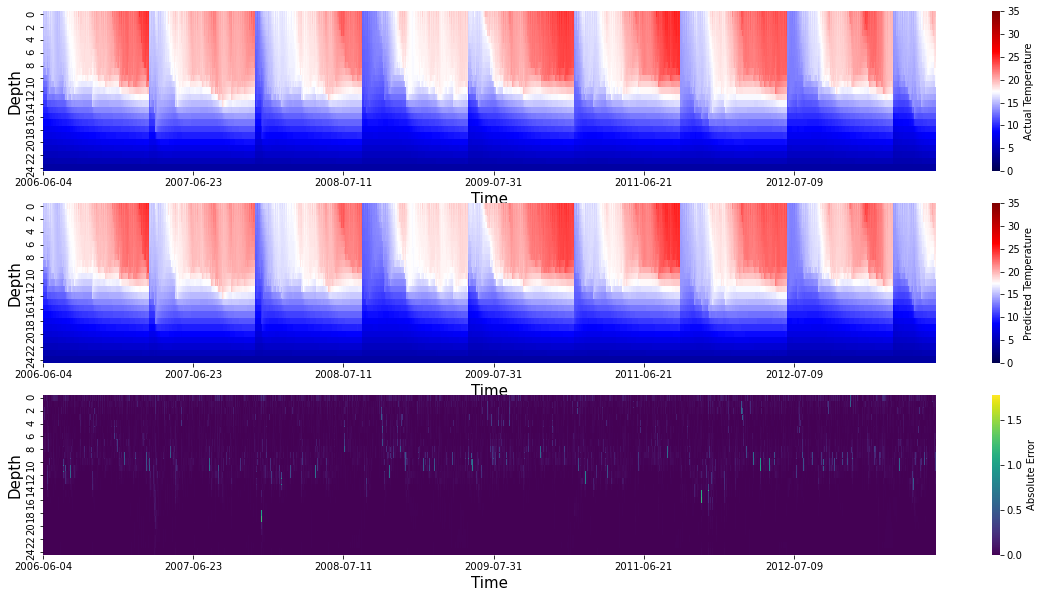

In [25]:
plot_output(train_y_pred, train_y_true, depth_steps, train_time, figsize=(20,10))

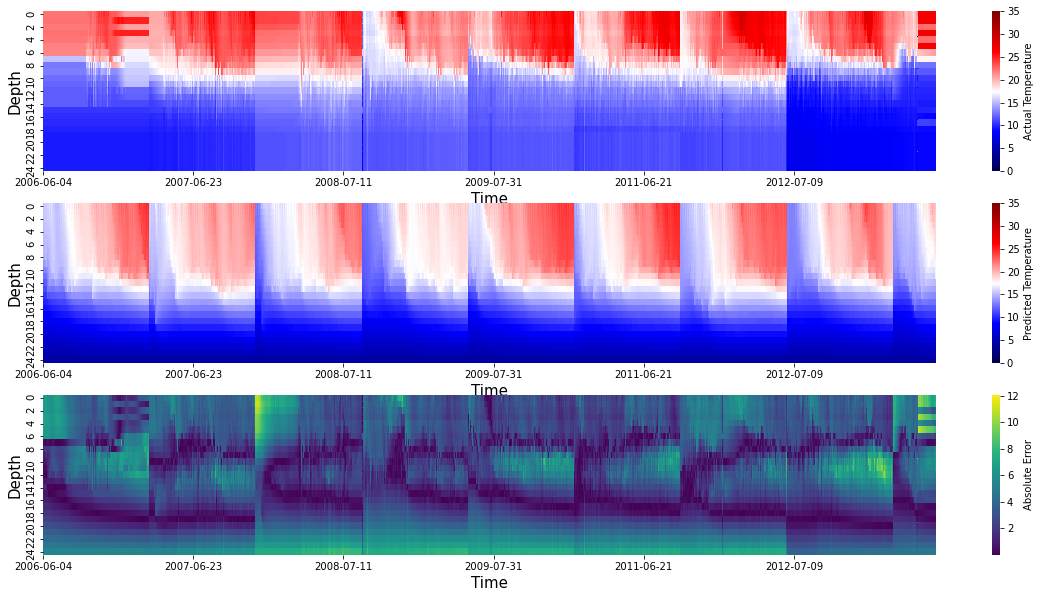

In [26]:
plot_output(train_y_pred, train_y_obs, depth_steps, train_time, figsize=(20,10))

## Test Results

In [27]:
test_y_pred, test_y_true, test_y_obs, test_rmse_models = get_rollout_predictions(heating_model,heat_diff_model, mixing_model, convection_model, ice_model, test_loader, plot = True)

test_rmse = rmse(test_y_pred.flatten(), test_y_true.flatten())
test_rmse_obs = rmse(test_y_pred.flatten(), test_y_obs.flatten())
test_l2 = l2_error(test_y_pred.flatten(), test_y_true.flatten())

print(f"Test RMSE Simulated: {test_rmse}")
print(f"Test RMSE Observed Temp: {test_rmse_obs}")
print(f"test L2 Error: {test_l2}")
print(f"The RMSEs after each modelling stage: {test_rmse_models.mean(axis=0)}")

RMSE of after m0 0.0011541428
RMSE of after m1 0.016101565
RMSE of after m2 0.09536987
RMSE of after m3 0.09543229
RMSE of after m4 0.09542019
RMSE of after m0 0.0012884701
RMSE of after m1 0.012483439
RMSE of after m2 0.048801947
RMSE of after m3 0.049057692
RMSE of after m4 0.049076643
RMSE of after m0 0.0013549231
RMSE of after m1 0.012336481
RMSE of after m2 0.06394777
RMSE of after m3 0.06439265
RMSE of after m4 0.06439663
RMSE of after m0 0.001573939
RMSE of after m1 0.008851846
RMSE of after m2 0.025957342
RMSE of after m3 0.031159176
RMSE of after m4 0.031139994
RMSE of after m0 0.0014333202
RMSE of after m1 0.0115318345
RMSE of after m2 0.07240617
RMSE of after m3 0.07389846
RMSE of after m4 0.07389637
RMSE of after m0 0.0013656919
RMSE of after m1 0.0100127235
RMSE of after m2 0.033582658
RMSE of after m3 0.034195893
RMSE of after m4 0.034216214
RMSE of after m0 0.0011776322
RMSE of after m1 0.011196873
RMSE of after m2 0.060541578
RMSE of after m3 0.060778193
RMSE of after m

RMSE of after m2 0.018760107
RMSE of after m3 0.02297491
RMSE of after m4 0.02295938
RMSE of after m0 0.0013753884
RMSE of after m1 0.008784375
RMSE of after m2 0.038486253
RMSE of after m3 0.039887372
RMSE of after m4 0.03988445
RMSE of after m0 0.0013535393
RMSE of after m1 0.0069053792
RMSE of after m2 0.018410712
RMSE of after m3 0.021988796
RMSE of after m4 0.021973047
RMSE of after m0 0.001130668
RMSE of after m1 0.005698955
RMSE of after m2 0.012274945
RMSE of after m3 0.012936796
RMSE of after m4 0.012921849
RMSE of after m0 0.0010747348
RMSE of after m1 0.006695893
RMSE of after m2 0.02906782
RMSE of after m3 0.0297588
RMSE of after m4 0.029762637
RMSE of after m0 0.0009190657
RMSE of after m1 0.008952232
RMSE of after m2 0.07464784
RMSE of after m3 0.07476712
RMSE of after m4 0.074765995
RMSE of after m0 0.0011771496
RMSE of after m1 0.012068776
RMSE of after m2 0.06399471
RMSE of after m3 0.064062275
RMSE of after m4 0.06405674
RMSE of after m0 0.0013743031
RMSE of after m1 

RMSE of after m0 0.0012254425
RMSE of after m1 0.012506419
RMSE of after m2 0.07401469
RMSE of after m3 0.0741496
RMSE of after m4 0.07414086
RMSE of after m0 0.0010641215
RMSE of after m1 0.008201752
RMSE of after m2 0.026510369
RMSE of after m3 0.02659008
RMSE of after m4 0.026592221
RMSE of after m0 0.001507225
RMSE of after m1 0.009387762
RMSE of after m2 0.058502086
RMSE of after m3 0.058608253
RMSE of after m4 0.058623474
RMSE of after m0 0.0014838201
RMSE of after m1 0.010077313
RMSE of after m2 0.055312276
RMSE of after m3 0.055545304
RMSE of after m4 0.05557138
RMSE of after m0 0.0011928235
RMSE of after m1 0.0093808435
RMSE of after m2 0.025599407
RMSE of after m3 0.026265671
RMSE of after m4 0.026266273
RMSE of after m0 0.001164292
RMSE of after m1 0.008055688
RMSE of after m2 0.037214875
RMSE of after m3 0.037456803
RMSE of after m4 0.037469286
RMSE of after m0 0.001488132
RMSE of after m1 0.008200572
RMSE of after m2 0.03108542
RMSE of after m3 0.03322063
RMSE of after m4 

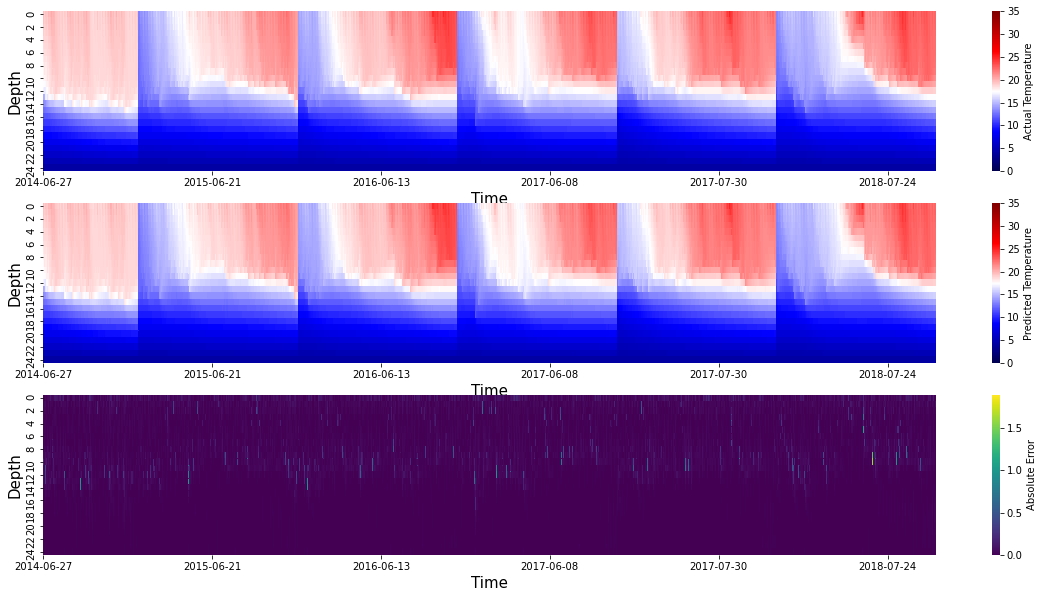

In [28]:
plot_output(test_y_pred, test_y_true, depth_steps, test_time, figsize=(20,10))

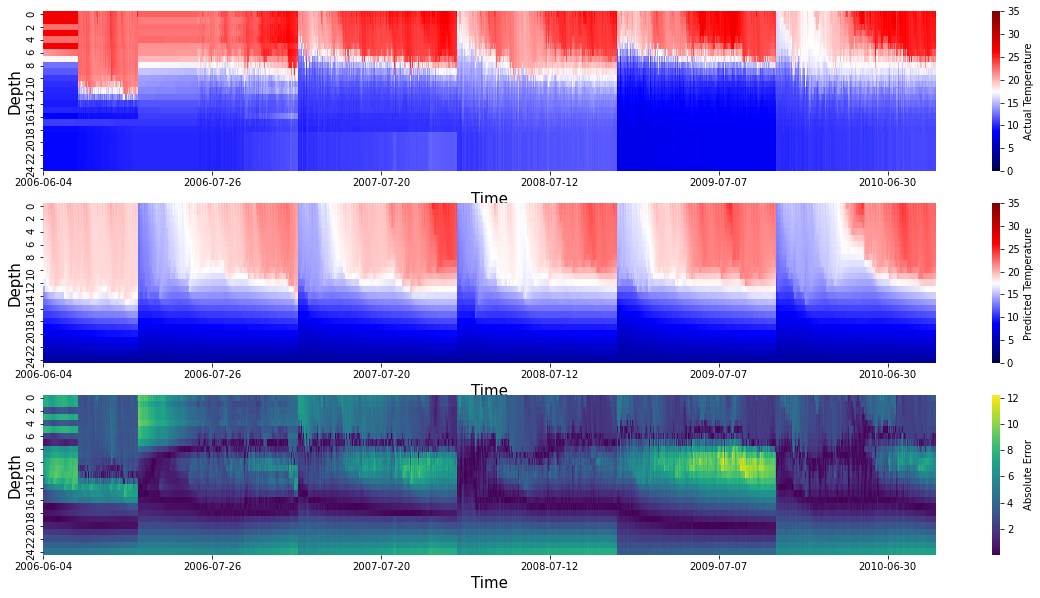

In [29]:
plot_output(test_y_pred, test_y_obs, depth_steps, train_time, figsize=(20,10))

# Evaluate ALL Models individually

## Heat Diffusion Model

In [30]:
train_rmse, train_l2_err = compute_metrics( heat_diff_model, train_loader, m1_input_column_ix, m1_output_column_ix, train_mean, train_std)
print(f"Train RMSE: {train_rmse}, Train L2 Error: {train_l2_err}")

test_rmse, test_l2_err = compute_metrics(heat_diff_model, test_loader, m1_input_column_ix, m1_output_column_ix, train_mean, train_std)
print(f"Test RMSE: {test_rmse}, Train L2 Error: {test_l2_err}")

Train RMSE: 12.78374249688134, Train L2 Error: 0.8337427173504972
Test RMSE: 12.898444002772136, Train L2 Error: 0.8351028717356513


## Mixing Model

In [31]:
train_rmse, train_l2_err = compute_metrics(mixing_model, train_loader, m2_input_column_ix, m2_output_column_ix, train_mean, train_std)
print(f"Train RMSE: {train_rmse}, Train L2 Error: {train_l2_err}")

test_rmse, test_l2_err = compute_metrics(mixing_model, test_loader, m2_input_column_ix, m2_output_column_ix, train_mean, train_std)
print(f"Test RMSE: {test_rmse}, Train L2 Error: {test_l2_err}")

Train RMSE: 0.04697958908507593, Train L2 Error: 0.0030637252879735055
Test RMSE: 0.04598526649073426, Train L2 Error: 0.0029770726607876415


## Convection Model

In [32]:
train_rmse, train_l2_err = compute_metrics(convection_model, train_loader, m3_input_column_ix, m3_output_column_ix, train_mean, train_std)
print(f"Train RMSE: {train_rmse}, Train L2 Error: {train_l2_err}")

test_rmse, test_l2_err = compute_metrics(convection_model, test_loader, m3_input_column_ix, m3_output_column_ix, train_mean, train_std)
print(f"Test RMSE: {test_rmse}, Train L2 Error: {test_l2_err}")

Train RMSE: 0.004543179681784685, Train L2 Error: 0.0002962804739826945
Test RMSE: 0.004928978264442002, Train L2 Error: 0.00031910286552458325


## Ice Model

In [33]:
train_rmse, train_l2_err = compute_metrics(ice_model, train_loader, m4_input_column_ix, m4_output_column_ix, train_mean, train_std)
print(f"Train RMSE: {train_rmse}, Train L2 Error: {train_l2_err}")

test_rmse, test_l2_err = compute_metrics(ice_model, test_loader, m4_input_column_ix, m4_output_column_ix, train_mean, train_std)
print(f"Test RMSE: {test_rmse}, Train L2 Error: {test_l2_err}")

Train RMSE: 0.00020992106922037695, Train L2 Error: 1.3689864421812881e-05
Test RMSE: 0.00021575026316656776, Train L2 Error: 1.3967707610073765e-05


# Finetuning

In [34]:
lr = 1e-5
# decay_rate = 0.1
# decay_steps = 500

params = list(heating_model.parameters()) + list(heat_diff_model.parameters()) + list(mixing_model.parameters()) + list(convection_model.parameters()) + list(ice_model.parameters())

optimizer = torch.optim.Adam(params, lr=lr, 
                             betas=(0.9, 0.999), eps=1e-08, weight_decay=0, amsgrad=False)
# lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=decay_steps, gamma=decay_rate)

criterion = torch.nn.MSELoss()

# Freeze model weights

In [35]:
def freeze_model(model):
    for param in model.parameters():
        param.requires_grad = False

def unfreeze_model(model):
    for param in model.parameters():
        param.requires_grad = True

In [36]:
#freeze_model(heating_model)
unfreeze_model(heating_model)
unfreeze_model(heat_diff_model)
unfreeze_model(mixing_model)
unfreeze_model(convection_model)
unfreeze_model(ice_model)


# Finetuning on Observed Temperature

In [37]:
heating_model.train()
heat_diff_model.train()
mixing_model.train()
convection_model.train()
ice_model.train()

n_epochs = 500

# mean and standard dev of "temp_total04" of model 4 output
mean_out4 = torch.tensor(train_mean[m4_output_column_ix[0]]).float().to(device)
std_out4 = torch.tensor(train_std[m4_output_column_ix[0]]).float().to(device)

mean_obs = torch.tensor(train_mean[obs_temp_columns_ix[0]]).float().to(device)
std_obs = torch.tensor(train_std[obs_temp_columns_ix[0]]).float().to(device)

# mean and standard dev of "input_temp" of model 1 input
m1_mean = torch.tensor(train_mean[m1_input_column_ix[-1]]).float().to(device)
m1_std = torch.tensor(train_std[m1_input_column_ix[-1]]).float().to(device)

train_loss = []
LOSS_m0 = []
LOSS_m1 = []
LOSS_m2 = []
LOSS_m3 = []
LOSS_m4 = []

for it in tqdm(range(n_epochs)):
    loss_epoch = 0
    loss_epoch_m0 = 0
    loss_epoch_m1 = 0
    loss_epoch_m2 = 0
    loss_epoch_m3 = 0
    loss_epoch_m4 = 0
    for ix, x in enumerate(iter(train_loader)):
        x = x.to(device).float()
        optimizer.zero_grad()
        
      #  m1_input = x[:, m1_input_column_ix]
        m0_input = x[:, m0_input_column_ix]
        
        #model 0
        m0_pred = heating_model(m0_input) #predicts diff and temp
        loss_m0 = criterion(m0_pred, x[:, m0_output_column_ix])

        #model 1
        m1_input = torch.cat([x[:, m1_input_column_ix[:-1]], m0_pred], dim=-1)
        # m1_pred = heat_diff_model(m1_input)
        
        proj = heat_diff_model(m1_input)
        pred = implicit_diffusion(proj, m0_pred)        
        m1_pred = pred.to(dtype=torch.float32)
                
        loss_m1 = criterion(m1_pred, x[:, m1_output_column_ix])
        
        #m1_pred = heat_diff_model(m1_input) #predicts diff and temp
        #m1_pred_temp = m1_pred[:,1:2]
            
        #loss_m1 = criterion(m1_pred_temp, x[:, m1_output_column_ix[1]].unsqueeze(1))

        #model 2
        m2_input = torch.cat([x[:, m2_input_column_ix[:-1]], m1_pred], dim=-1)
        m2_pred = mixing_model(m2_input)
            
        loss_m2 = criterion(m2_pred, x[:, m2_output_column_ix])

        #model 3
        m3_input = torch.cat([x[:, m3_input_column_ix[:-1]], m2_pred], dim=-1)
        m3_pred = convection_model(m3_input)

        loss_m3 = criterion(m3_pred, x[:, m3_output_column_ix])

        #model 4
        m4_input = torch.cat([x[:, m4_input_column_ix[:-1]], m3_pred], dim=-1)
        m4_pred = ice_model(m4_input)
        
        obs_temp_true = x[:, obs_temp_columns_ix] * std_obs + mean_obs
        obs_temp_true_norm = (obs_temp_true - mean_out4)/std_out4
        
        loss_m4 = criterion(m4_pred, obs_temp_true_norm)

        #loss = (loss_m0 + loss_m1 + loss_m2 + loss_m3 + loss_m4)
        
        loss = loss_m4
        
        loss.backward()
        optimizer.step()
        
        loss_epoch += loss.item()
        loss_epoch_m0 += loss_m0.item()
        loss_epoch_m1 += loss_m1.item()
        loss_epoch_m2 += loss_m2.item()
        loss_epoch_m3 += loss_m3.item()
        loss_epoch_m4 += loss_m4.item()
    
    loss_epoch = loss_epoch/len(train_loader)
    loss_epoch_m0 = loss_epoch_m0/len(train_loader)
    loss_epoch_m1 = loss_epoch_m1/len(train_loader)
    loss_epoch_m2 = loss_epoch_m2/len(train_loader)
    loss_epoch_m3 = loss_epoch_m3/len(train_loader)
    loss_epoch_m4 = loss_epoch_m4/len(train_loader)
    
    train_loss.append(loss_epoch)
    LOSS_m0.append(loss_epoch_m0)
    LOSS_m1.append(loss_epoch_m1)
    LOSS_m2.append(loss_epoch_m2)
    LOSS_m3.append(loss_epoch_m3)
    LOSS_m4.append(loss_epoch_m4)
    if it % 50 == 0:
        print(f"Epoch : {it}, Train_loss: {train_loss[-1]}, Loss m0: {LOSS_m0[-1]}, Loss m1: {LOSS_m1[-1]}, Loss m2: {LOSS_m2[-1]}, Loss m3: {LOSS_m3[-1]}, Loss m4: {LOSS_m4[-1]}")
    
    #plot the loss_m1, m2


  0%|          | 1/500 [00:04<41:22,  4.98s/it]

Epoch : 0, Train_loss: 0.3837980429498141, Loss m0: 0.0006915678898538252, Loss m1: 0.0006952871755090853, Loss m2: 0.0027782796785918466, Loss m3: 0.005605342719388849, Loss m4: 0.3837980429498141


 10%|█         | 51/500 [04:28<41:58,  5.61s/it]

Epoch : 50, Train_loss: 0.09660191700525032, Loss m0: 0.052833964048116, Loss m1: 0.05383539498602384, Loss m2: 0.20359537180438136, Loss m3: 0.2691188305616379, Loss m4: 0.09660191700525032


 20%|██        | 101/500 [10:43<45:20,  6.82s/it] 

Epoch : 100, Train_loss: 0.08531960678105587, Loss m0: 0.07707931105072466, Loss m1: 0.07733566732764643, Loss m2: 0.24967185357873073, Loss m3: 0.3097508709702716, Loss m4: 0.08531960678105587


 30%|███       | 151/500 [16:03<35:07,  6.04s/it]  

Epoch : 150, Train_loss: 0.08200241537489647, Loss m0: 0.09276201947273424, Loss m1: 0.09208642382599763, Loss m2: 0.2686916252210636, Loss m3: 0.32750270760699407, Loss m4: 0.08200241537489647


 40%|████      | 201/500 [20:54<28:05,  5.64s/it]

Epoch : 200, Train_loss: 0.08024977984831937, Loss m0: 0.1022560807607518, Loss m1: 0.10099283633316124, Loss m2: 0.2775224971291203, Loss m3: 0.3368448608073612, Loss m4: 0.08024977984831937


 50%|█████     | 251/500 [25:35<23:16,  5.61s/it]

Epoch : 250, Train_loss: 0.07911688794738195, Loss m0: 0.10850122217213948, Loss m1: 0.10706613542849586, Loss m2: 0.28198548846396826, Loss m3: 0.3426691375722821, Loss m4: 0.07911688794738195


 60%|██████    | 301/500 [30:24<19:21,  5.83s/it]

Epoch : 300, Train_loss: 0.0783261337736309, Loss m0: 0.11288456325012966, Loss m1: 0.11164227651819687, Loss m2: 0.28418518827865585, Loss m3: 0.34664992868100236, Loss m4: 0.0783261337736309


 70%|███████   | 351/500 [34:23<08:34,  3.46s/it]

Epoch : 350, Train_loss: 0.07774728190328851, Loss m0: 0.11606083529057519, Loss m1: 0.1152886737063027, Loss m2: 0.2850868094887509, Loss m3: 0.3495342512458763, Loss m4: 0.07774728190328851


 80%|████████  | 401/500 [37:14<05:37,  3.41s/it]

Epoch : 400, Train_loss: 0.07730617698894551, Loss m0: 0.11836600179890258, Loss m1: 0.11825557816898663, Loss m2: 0.2851884782614324, Loss m3: 0.3517149159772284, Loss m4: 0.07730617698894551


 90%|█████████ | 451/500 [40:37<03:20,  4.09s/it]

Epoch : 450, Train_loss: 0.07695723912872424, Loss m0: 0.1200000548222721, Loss m1: 0.12067712809665491, Loss m2: 0.2847622942504467, Loss m3: 0.3534170389175415, Loss m4: 0.07695723912872424


100%|██████████| 500/500 [43:53<00:00,  5.27s/it]


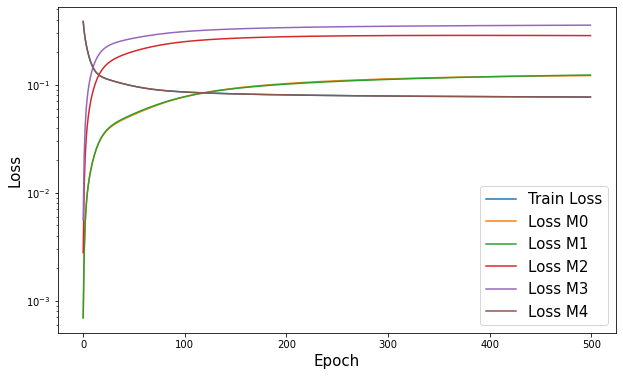

In [38]:
plt.figure(figsize=(10,6))
plt.plot(train_loss, label = "Train Loss")
plt.plot(LOSS_m0, label = "Loss M0")
plt.plot(LOSS_m1, label = "Loss M1")
plt.plot(LOSS_m2, label = "Loss M2")
plt.plot(LOSS_m3, label = "Loss M3")
plt.plot(LOSS_m4, label = "Loss M4")
plt.ylabel("Loss", fontsize=15)
plt.xlabel("Epoch", fontsize=15)
plt.yscale("log")
plt.legend(fontsize=15)
plt.show()

# Rollout Evaluation After FineTuning

In [39]:
train_y_pred, train_y_true, train_y_obs, train_rmse_models = get_rollout_predictions(heating_model, heat_diff_model, mixing_model, convection_model, ice_model, train_loader, plot = True)

train_rmse = rmse(train_y_pred.flatten(), train_y_true.flatten())
train_rmse_obs = rmse(train_y_pred.flatten(), train_y_obs.flatten())
train_l2 = l2_error(train_y_pred.flatten(), train_y_true.flatten())

print(f"Train RMSE Simulated: {train_rmse}")
print(f"Train RMSE Observed Temp: {train_rmse_obs}")
print(f"Train L2 Error: {train_l2}")
print(f"The RMSEs after each modelling stage: {train_rmse_models.mean(axis=0)}")

RMSE of after m0 1.6361699
RMSE of after m1 1.6229895
RMSE of after m2 2.8532
RMSE of after m3 3.2433207
RMSE of after m4 3.2093925
RMSE of after m0 1.7015028
RMSE of after m1 1.7135113
RMSE of after m2 3.0190446
RMSE of after m3 3.3738167
RMSE of after m4 3.3319476
RMSE of after m0 1.6769971
RMSE of after m1 1.7163378
RMSE of after m2 3.0152316
RMSE of after m3 3.3576748
RMSE of after m4 3.3510456
RMSE of after m0 1.2517473
RMSE of after m1 1.2431448
RMSE of after m2 2.7077596
RMSE of after m3 3.0653007
RMSE of after m4 3.1144068
RMSE of after m0 1.3836502
RMSE of after m1 1.350942
RMSE of after m2 2.7038739
RMSE of after m3 3.0467644
RMSE of after m4 3.1205022
RMSE of after m0 1.542554
RMSE of after m1 1.5594846
RMSE of after m2 2.8088994
RMSE of after m3 3.1524086
RMSE of after m4 3.223014
RMSE of after m0 1.5710807
RMSE of after m1 1.5862045
RMSE of after m2 2.8460827
RMSE of after m3 3.203424
RMSE of after m4 3.2446837
RMSE of after m0 1.8209065
RMSE of after m1 1.856209
RMSE of a

RMSE of after m3 3.2549524
RMSE of after m4 3.2709212
RMSE of after m0 1.5133911
RMSE of after m1 1.5293366
RMSE of after m2 2.7623656
RMSE of after m3 3.1273112
RMSE of after m4 3.1893451
RMSE of after m0 1.5423019
RMSE of after m1 1.540989
RMSE of after m2 2.7826095
RMSE of after m3 3.1780386
RMSE of after m4 3.2353773
RMSE of after m0 1.5945532
RMSE of after m1 1.5590544
RMSE of after m2 2.7799008
RMSE of after m3 3.1635585
RMSE of after m4 3.2490048
RMSE of after m0 1.5931913
RMSE of after m1 1.6035389
RMSE of after m2 2.7743049
RMSE of after m3 3.1451359
RMSE of after m4 3.241524
RMSE of after m0 1.556446
RMSE of after m1 1.5720242
RMSE of after m2 2.7689652
RMSE of after m3 3.1520061
RMSE of after m4 3.2302632
RMSE of after m0 1.5317122
RMSE of after m1 1.5198101
RMSE of after m2 2.7263174
RMSE of after m3 3.100319
RMSE of after m4 3.1904044
RMSE of after m0 1.5364739
RMSE of after m1 1.5573156
RMSE of after m2 2.7488444
RMSE of after m3 3.1107326
RMSE of after m4 3.2035954
RMSE 

RMSE of after m3 3.2385302
RMSE of after m4 3.28643
RMSE of after m0 1.3112798
RMSE of after m1 1.4074993
RMSE of after m2 2.643572
RMSE of after m3 3.0288143
RMSE of after m4 3.0758402
RMSE of after m0 1.1740491
RMSE of after m1 1.2113502
RMSE of after m2 2.5033555
RMSE of after m3 2.842828
RMSE of after m4 2.8897305
RMSE of after m0 1.2434019
RMSE of after m1 1.267756
RMSE of after m2 2.597476
RMSE of after m3 2.9355385
RMSE of after m4 2.9759405
RMSE of after m0 1.4808354
RMSE of after m1 1.4887192
RMSE of after m2 2.7299387
RMSE of after m3 3.0669193
RMSE of after m4 3.1017165
RMSE of after m0 1.5394359
RMSE of after m1 1.5625118
RMSE of after m2 2.7499182
RMSE of after m3 3.1117811
RMSE of after m4 3.1964636
RMSE of after m0 1.5522572
RMSE of after m1 1.5947441
RMSE of after m2 2.7671793
RMSE of after m3 3.0965486
RMSE of after m4 3.1795142
RMSE of after m0 1.7213686
RMSE of after m1 1.7222257
RMSE of after m2 2.8291724
RMSE of after m3 3.1288664
RMSE of after m4 3.2151659
RMSE of

RMSE of after m1 1.75844
RMSE of after m2 2.839536
RMSE of after m3 3.2598817
RMSE of after m4 3.2767062
RMSE of after m0 1.8537139
RMSE of after m1 1.905091
RMSE of after m2 3.0321667
RMSE of after m3 3.4581065
RMSE of after m4 3.4227755
RMSE of after m0 1.7917076
RMSE of after m1 1.8380511
RMSE of after m2 2.9950202
RMSE of after m3 3.4101777
RMSE of after m4 3.4035125
RMSE of after m0 1.6386467
RMSE of after m1 1.6414135
RMSE of after m2 2.7957482
RMSE of after m3 3.207959
RMSE of after m4 3.2784305
RMSE of after m0 1.8781631
RMSE of after m1 1.9031183
RMSE of after m2 3.039599
RMSE of after m3 3.4629524
RMSE of after m4 3.4869032
RMSE of after m0 1.808333
RMSE of after m1 1.8669939
RMSE of after m2 2.9704204
RMSE of after m3 3.391239
RMSE of after m4 3.4358845
RMSE of after m0 2.0086603
RMSE of after m1 2.0634072
RMSE of after m2 3.125462
RMSE of after m3 3.5505555
RMSE of after m4 3.5606916
RMSE of after m0 2.051546
RMSE of after m1 2.1053748
RMSE of after m2 3.1203222
RMSE of aft

RMSE of after m2 3.0504773
RMSE of after m3 3.4188428
RMSE of after m4 3.4036963
RMSE of after m0 1.9103926
RMSE of after m1 1.9378952
RMSE of after m2 3.0836015
RMSE of after m3 3.43807
RMSE of after m4 3.4523964
RMSE of after m0 1.81378
RMSE of after m1 1.8348851
RMSE of after m2 3.0853467
RMSE of after m3 3.452329
RMSE of after m4 3.436039
RMSE of after m0 1.6973493
RMSE of after m1 1.707461
RMSE of after m2 2.9643185
RMSE of after m3 3.3244362
RMSE of after m4 3.342915
RMSE of after m0 1.5676606
RMSE of after m1 1.5857248
RMSE of after m2 2.9347384
RMSE of after m3 3.2561307
RMSE of after m4 3.3058383
RMSE of after m0 1.6805751
RMSE of after m1 1.681967
RMSE of after m2 3.0451238
RMSE of after m3 3.4097934
RMSE of after m4 3.4357154
RMSE of after m0 1.9224765
RMSE of after m1 1.9301779
RMSE of after m2 3.1824327
RMSE of after m3 3.544215
RMSE of after m4 3.5687752
RMSE of after m0 2.0385156
RMSE of after m1 2.0856943
RMSE of after m2 3.2469342
RMSE of after m3 3.5968018
RMSE of aft

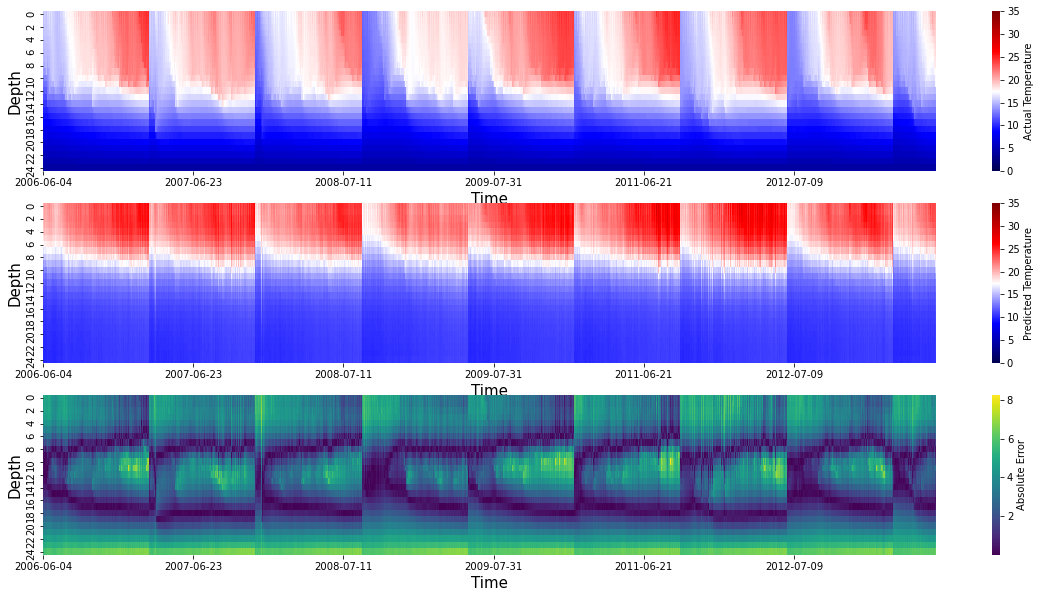

In [40]:
plot_output(train_y_pred, train_y_true, depth_steps, train_time, figsize=(20,10))

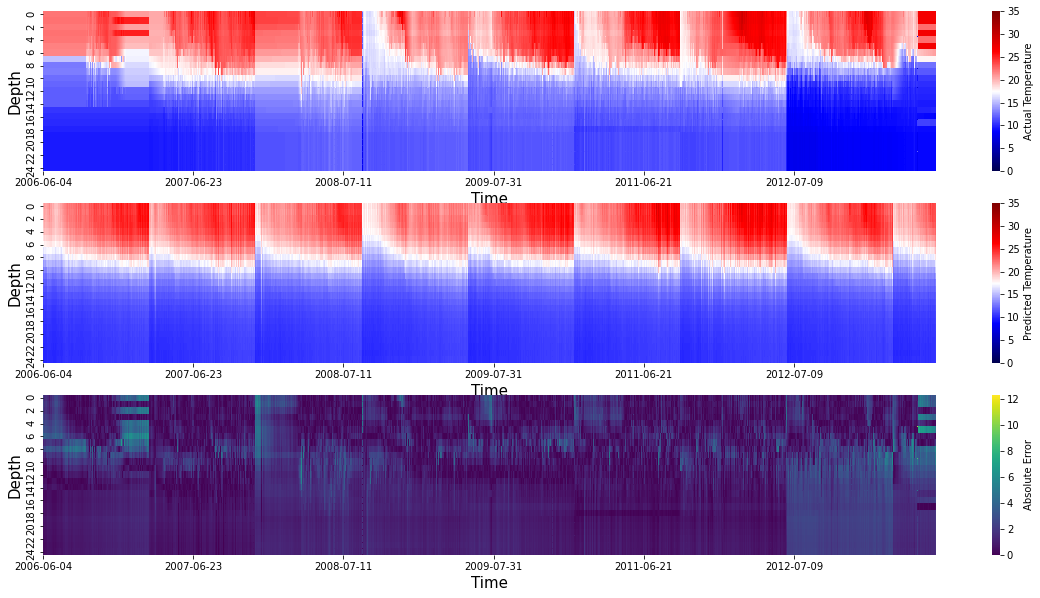

In [41]:
plot_output(train_y_pred, train_y_obs, depth_steps, train_time, figsize=(20,10))

In [42]:
test_y_pred, test_y_true, test_y_obs, test_rmse_models = get_rollout_predictions(heating_model, heat_diff_model, mixing_model, convection_model, ice_model, test_loader, plot = True)

test_rmse = rmse(test_y_pred.flatten(), test_y_true.flatten())
test_rmse_obs = rmse(test_y_pred.flatten(), test_y_obs.flatten())
test_l2 = l2_error(test_y_pred.flatten(), test_y_true.flatten())

print(f"Test RMSE Simulated: {test_rmse}")
print(f"Test RMSE Observed Temp: {test_rmse_obs}")
print(f"test L2 Error: {test_l2}")
print(f"The RMSEs after each modelling stage: {test_rmse_models.mean(axis=0)}")

RMSE of after m0 1.6113685
RMSE of after m1 1.6089456
RMSE of after m2 2.7794695
RMSE of after m3 3.109741
RMSE of after m4 3.1893435
RMSE of after m0 1.8488705
RMSE of after m1 1.8488342
RMSE of after m2 2.9725938
RMSE of after m3 3.3061008
RMSE of after m4 3.3891044
RMSE of after m0 2.051145
RMSE of after m1 2.0083213
RMSE of after m2 3.0459766
RMSE of after m3 3.4105139
RMSE of after m4 3.5140665
RMSE of after m0 2.0739
RMSE of after m1 2.0347464
RMSE of after m2 3.0794773
RMSE of after m3 3.4625895
RMSE of after m4 3.5592978
RMSE of after m0 1.9278532
RMSE of after m1 1.927594
RMSE of after m2 3.0515008
RMSE of after m3 3.4727957
RMSE of after m4 3.5547466
RMSE of after m0 2.0664365
RMSE of after m1 2.0460641
RMSE of after m2 3.1065624
RMSE of after m3 3.4551115
RMSE of after m4 3.5572062
RMSE of after m0 2.0799356
RMSE of after m1 2.0783925
RMSE of after m2 3.139931
RMSE of after m3 3.562902
RMSE of after m4 3.6409526
RMSE of after m0 2.0542579
RMSE of after m1 2.0552554
RMSE of a

RMSE of after m1 1.7695419
RMSE of after m2 2.8211281
RMSE of after m3 3.1646214
RMSE of after m4 3.257356
RMSE of after m0 1.8915349
RMSE of after m1 1.8744366
RMSE of after m2 2.8930578
RMSE of after m3 3.1495793
RMSE of after m4 3.245911
RMSE of after m0 2.0926342
RMSE of after m1 2.051435
RMSE of after m2 3.0524843
RMSE of after m3 3.3356667
RMSE of after m4 3.4409072
RMSE of after m0 2.245385
RMSE of after m1 2.1992626
RMSE of after m2 3.1152248
RMSE of after m3 3.4187489
RMSE of after m4 3.5259595
RMSE of after m0 2.4920228
RMSE of after m1 2.448286
RMSE of after m2 3.2292955
RMSE of after m3 3.5290582
RMSE of after m4 3.6325846
RMSE of after m0 2.3642466
RMSE of after m1 2.3167593
RMSE of after m2 3.1990957
RMSE of after m3 3.4764214
RMSE of after m4 3.5865993
RMSE of after m0 2.2869134
RMSE of after m1 2.2809901
RMSE of after m2 3.0984073
RMSE of after m3 3.420389
RMSE of after m4 3.5213323
RMSE of after m0 2.4223907
RMSE of after m1 2.4054549
RMSE of after m2 3.1836424
RMSE of

RMSE of after m1 2.5111876
RMSE of after m2 3.1718614
RMSE of after m3 3.4288325
RMSE of after m4 3.5339868
RMSE of after m0 2.3854842
RMSE of after m1 2.409738
RMSE of after m2 3.0689623
RMSE of after m3 3.3327065
RMSE of after m4 3.431218
RMSE of after m0 2.3172293
RMSE of after m1 2.3487868
RMSE of after m2 3.0272796
RMSE of after m3 3.331292
RMSE of after m4 3.4311836
RMSE of after m0 2.381673
RMSE of after m1 2.390713
RMSE of after m2 3.0623975
RMSE of after m3 3.330371
RMSE of after m4 3.4337459
RMSE of after m0 2.6504211
RMSE of after m1 2.5772908
RMSE of after m2 3.2812884
RMSE of after m3 3.5252306
RMSE of after m4 3.6323595
RMSE of after m0 2.7085903
RMSE of after m1 2.621654
RMSE of after m2 3.326969
RMSE of after m3 3.5799356
RMSE of after m4 3.6855588
RMSE of after m0 2.4278626
RMSE of after m1 2.3911176
RMSE of after m2 3.1583695
RMSE of after m3 3.444884
RMSE of after m4 3.5508204
RMSE of after m0 2.3678708
RMSE of after m1 2.350843
RMSE of after m2 3.1211977
RMSE of aft

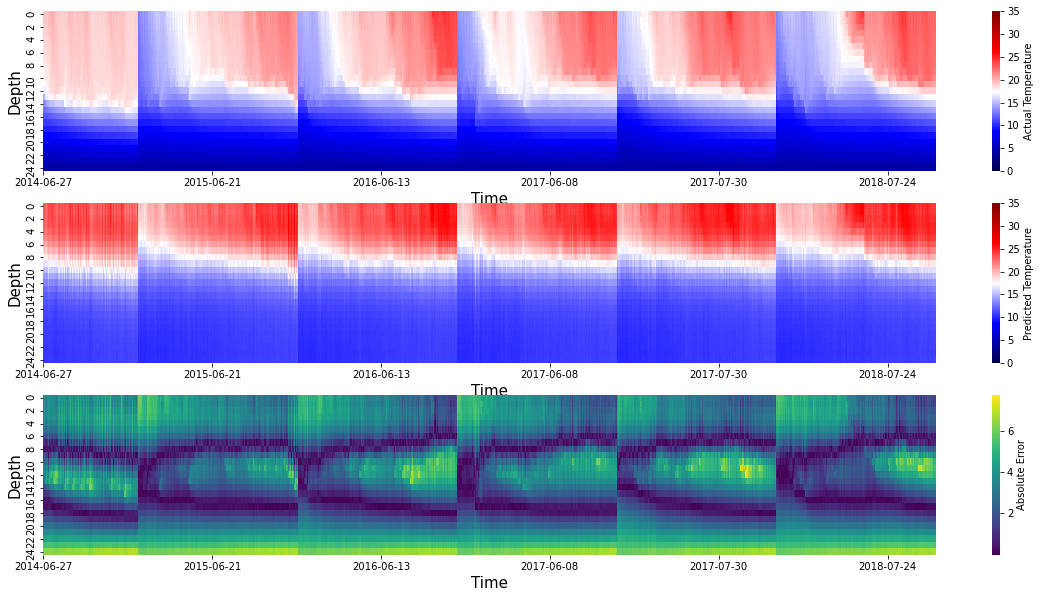

In [43]:
plot_output(test_y_pred, test_y_true, depth_steps, test_time, figsize=(20,10))

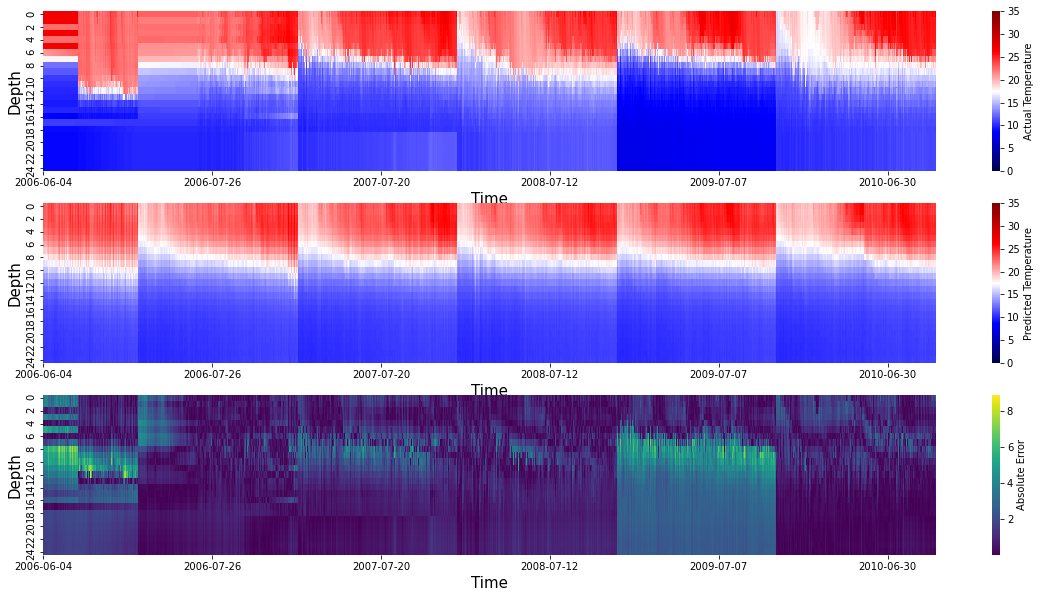

In [44]:
plot_output(test_y_pred, test_y_obs, depth_steps, train_time, figsize=(20,10))

# Evaluate ALL Models individually

## Heat Diffusion Model

In [45]:
train_rmse, train_l2_err = compute_metrics(heat_diff_model, train_loader, m1_input_column_ix, m1_output_column_ix, train_mean, train_std)
print(f"Train RMSE: {train_rmse}, Train L2 Error: {train_l2_err}")

test_rmse, test_l2_err = compute_metrics(heat_diff_model, test_loader, m1_input_column_ix, m1_output_column_ix, train_mean, train_std)
print(f"Test RMSE: {test_rmse}, Train L2 Error: {test_l2_err}")

Train RMSE: 225.4416461739962, Train L2 Error: 14.703075467213987
Test RMSE: 230.56052494671636, Train L2 Error: 14.927518113851637


## Mixing Model

In [46]:
train_rmse, train_l2_err = compute_metrics(mixing_model, train_loader, m2_input_column_ix, m2_output_column_ix, train_mean, train_std)
print(f"Train RMSE: {train_rmse}, Train L2 Error: {train_l2_err}")

test_rmse, test_l2_err = compute_metrics(mixing_model, test_loader, m2_input_column_ix, m2_output_column_ix, train_mean, train_std)
print(f"Test RMSE: {test_rmse}, Train L2 Error: {test_l2_err}")

Train RMSE: 1.8899514139064224, Train L2 Error: 0.12325122574700852
Test RMSE: 1.9128680904465658, Train L2 Error: 0.12383851895060753


## Convection Model

In [47]:
train_rmse, train_l2_err = compute_metrics(convection_model, train_loader, m3_input_column_ix, m3_output_column_ix, train_mean, train_std)
print(f"Train RMSE: {train_rmse}, Train L2 Error: {train_l2_err}")

test_rmse, test_l2_err = compute_metrics(convection_model, test_loader, m3_input_column_ix, m3_output_column_ix, train_mean, train_std)
print(f"Test RMSE: {test_rmse}, Train L2 Error: {test_l2_err}")

Train RMSE: 1.0612373735583611, Train L2 Error: 0.06920789712690978
Test RMSE: 1.0705601831281975, Train L2 Error: 0.06930824276852524


## Ice Model

In [48]:
train_rmse, train_l2_err = compute_metrics(ice_model, train_loader, m4_input_column_ix, m4_output_column_ix, train_mean, train_std)
print(f"Train RMSE: {train_rmse}, Train L2 Error: {train_l2_err}")

test_rmse, test_l2_err = compute_metrics(ice_model, test_loader, m4_input_column_ix, m4_output_column_ix, train_mean, train_std)
print(f"Test RMSE: {test_rmse}, Train L2 Error: {test_l2_err}")

Train RMSE: 0.8134394771038859, Train L2 Error: 0.05304792033624802
Test RMSE: 0.819425085580118, Train L2 Error: 0.05304971514637915


# Compute Model Similarity after Finetuning

In [49]:
def compute_model_similarity(model1, model2):
    weight1 = []
    weight2 = []
    for param1, param2 in zip(model1.parameters(), model2.parameters()):
        weight1.append(param1.detach().clone().flatten())
        weight2.append(param2.detach().clone().flatten())
    weight1 = torch.cat(weight1, dim=0)
    weight2 = torch.cat(weight2, dim=0)
    
    #Cosine Similarity
    cos = nn.CosineSimilarity(dim=0, eps=1e-8)
    cos_sim = cos(weight1, weight2)
    
    #L2 norm
    l2 = torch.norm((weight1-weight2), p='fro', dim=0)
    
    return cos_sim, l2

In [50]:
heating_model_init = MLP(m0_layers, activation="gelu")
heating_model_init.load_state_dict(m0_checkpoint)
heating_model_init = heating_model_init.to(device)

cos_sim, l2_dist = compute_model_similarity(heating_model_init, heating_model)

print(f"Cosine Similarity: {cos_sim}")
print(f"L2 Norm: {l2_dist}")

Initializing Network with Xavier Initialization..
Cosine Similarity: 0.9779837727546692
L2 Norm: 2.024423122406006


In [51]:
heat_diff_model_init = MLP(m1_layers, activation="gelu")
heat_diff_model_init.load_state_dict(m1_checkpoint)
heat_diff_model_init = heat_diff_model_init.to(device)

cos_sim, l2_dist = compute_model_similarity(heat_diff_model_init, heat_diff_model)

print(f"Cosine Similarity: {cos_sim}")
print(f"L2 Norm: {l2_dist}")

Initializing Network with Xavier Initialization..
Cosine Similarity: 0.8615292906761169
L2 Norm: 7.2070770263671875


In [52]:
mixing_model_init = MLP(m2_layers, activation="gelu")
mixing_model_init.load_state_dict(m2_checkpoint)
mixing_model_init = mixing_model_init.to(device)

cos_sim, l2_dist = compute_model_similarity(mixing_model_init, mixing_model)

print(f"Cosine Similarity: {cos_sim}")
print(f"L2 Norm: {l2_dist}")

Initializing Network with Xavier Initialization..
Cosine Similarity: 0.9874047636985779
L2 Norm: 1.3325711488723755


In [53]:
convection_model_init = MLP(m3_layers, activation="gelu")
convection_model_init.load_state_dict(m3_checkpoint)
convection_model_init = convection_model_init.to(device)

cos_sim, l2_dist = compute_model_similarity(convection_model_init, convection_model)

print(f"Cosine Similarity: {cos_sim}")
print(f"L2 Norm: {l2_dist}")

Initializing Network with Xavier Initialization..
Cosine Similarity: 0.9949147701263428
L2 Norm: 0.6886278986930847


In [54]:
ice_model_init = MLP(m4_layers, activation="gelu")
ice_model_init.load_state_dict(m4_checkpoint)
ice_model_init = ice_model_init.to(device)

cos_sim, l2_dist = compute_model_similarity(ice_model_init, ice_model)

print(f"Cosine Similarity: {cos_sim}")
print(f"L2 Norm: {l2_dist}")

Initializing Network with Xavier Initialization..
Cosine Similarity: 0.995433509349823
L2 Norm: 0.6184704303741455


In [55]:
# Freeze all models again and compute finetuned diffusivity values

In [56]:
#freeze_model(heating_model)
freeze_model(mixing_model)
freeze_model(convection_model)
freeze_model(ice_model)
freeze_model(heat_diff_model)
freeze_model(heating_model)

In [57]:
heating_model.train()
heat_diff_model.train()
mixing_model.train()
convection_model.train()
ice_model.train()

n_epochs = 500

# mean and standard dev of "temp_total04" of model 4 output
mean_out4 = torch.tensor(train_mean[m4_output_column_ix[0]]).float().to(device)
std_out4 = torch.tensor(train_std[m4_output_column_ix[0]]).float().to(device)

mean_obs = torch.tensor(train_mean[obs_temp_columns_ix[0]]).float().to(device)
std_obs = torch.tensor(train_std[obs_temp_columns_ix[0]]).float().to(device)

# mean and standard dev of "input_temp" of model 1 input
m1_mean = torch.tensor(train_mean[m1_input_column_ix[-1]]).float().to(device)
m1_std = torch.tensor(train_std[m1_input_column_ix[-1]]).float().to(device)

train_loss = []
LOSS_m0 = []
LOSS_m1 = []
LOSS_m2 = []
LOSS_m3 = []
LOSS_m4 = []

diffusivity = []

for ix, x in enumerate(iter(train_loader)):
    x = x.to(device).float()
    optimizer.zero_grad()
        
      #  m1_input = x[:, m1_input_column_ix]
    m0_input = x[:, m0_input_column_ix]
        
        #model 0
    m0_pred = heating_model(m0_input) #predicts diff and temp
    loss_m0 = criterion(m0_pred, x[:, m0_output_column_ix])

        #model 1
    m1_input = torch.cat([x[:, m1_input_column_ix[:-1]], m0_pred], dim=-1)
        # m1_pred = heat_diff_model(m1_input)
        
    proj = heat_diff_model(m1_input)
    pred = implicit_diffusion(proj, m0_pred)        
    m1_pred = pred.to(dtype=torch.float32)
    

                
    loss_m1 = criterion(m1_pred, x[:, m1_output_column_ix])
        
    diffusivity.append(proj)

    

diffusivity_ = torch.cat(diffusivity, dim=0) 
    
        


#diffusivity_ = diffusivity_.flatten().detach().cpu().numpy()
#print(diffusivity_.shape)
    
#diffusivity_ = np.reshape(diffusivity_, (diffusivity_.shape[0]//depth_steps, depth_steps))

#print(diffusivity_.shape)

(297325,)
0.0012746669
-0.0001854307
[3.73840547e-05]
[2.51789534e-06]
298
(297325, 23)
(297325,)
[0]
(297325, 1)
[-1.66410059]
<bound method NDFrame.head of            depth  diffusivity_finetuned
0      -1.664101              88.454147
1      -1.525426              78.760429
2      -1.386750              71.619804
3      -1.248075              66.814178
4      -1.109400              64.022507
...          ...                    ...
297320  1.109400              -1.783914
297321  1.248075              -1.577930
297322  1.386750              -1.442334
297323  1.525426              -1.554358
297324  1.664101              -1.485250

[297325 rows x 2 columns]>
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 297325 entries, 0 to 297324
Data columns (total 2 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   depth                  297325 non-null  float64
 1   diffusivity_finetuned  297325 non-null  float32
dtypes: floa

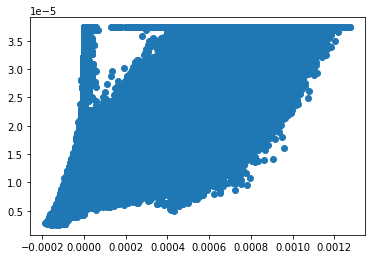

In [58]:
torch.save(diffusivity, 'diffusivity.t')


diffusivity_ = torch.cat(diffusivity, dim=0) 
diffusivity_ = diffusivity_.flatten().detach().cpu().numpy()
print(diffusivity_.shape)

#print(train_data.shape)
#print(data_df.shape)

diff_input_columns = [ 'diffusivity']

diff_input_column_ix = [data_df.columns.get_loc(column) for column in diff_input_columns]

#print(diff_input_column_ix)

mean_diff = torch.tensor(input_mean[m1_input_column_ix[13]]).to(device)
std_diff = torch.tensor(input_std[m1_input_column_ix[13]]).to(device)

diff_train = train_data[:, diff_input_column_ix]

#print(std_diff)
#print(mean_diff)

diff_dl = diffusivity_ * 1.0687e-05 + 1.9475e-05
diff_pb = diff_train * 1.0687e-05 + 1.9475e-05

#plt.scatter(diffusivity_ , train_data[:, diff_input_column_ix])
plt.scatter(diff_dl, diff_pb)

print(max(diff_dl))
print(min(diff_dl))

print(max(diff_pb))
print(min(diff_pb))

print(len(diffusivity))
print(train_data.shape)
print(diffusivity_.shape)



depth_input_columns = ['depth']
depth_input_column_ix = [data_df.columns.get_loc(column) for column in depth_input_columns]

print(depth_input_column_ix)

depth_df = train_data[:, depth_input_column_ix]
print(depth_df.shape)

test = pd.DataFrame(data={'depth':list(depth_df),
                  'diffusivity_finetuned':diffusivity_[:,]})
print(test['depth'][0])
test['depth'] = test['depth'].astype(float)  

print(test.head)
print(test.info())

#X = train_data.merge(test, how='inner', on=['depth'])
diff_df = test.iloc[:, 1].to_numpy()

print(diff_df[:,].shape)
print(train_data[:,].shape)

df = pd.DataFrame(diffusivity) 
print(len(diffusivity))
print(df.shape)
#print(diffusivity.info())
# saving the dataframe 
df.to_csv('finetuned_diff.csv') 

df2 = pd.DataFrame(diffusivity_) 
#print(diffusivity.info())
# saving the dataframe 
df2.to_csv('finetuned_diff_.csv') 

test_ = torch.cat(diffusivity, dim=0) 
test_ = test_.flatten().detach().cpu().numpy()
print(test_.shape)

def shape(lst):
    length = len(lst)
    shp = tuple(shape(sub) if isinstance(sub, list) else 0 for sub in lst)
    if any(x != 0 for x in shp):
        return length, shp
    else:
        return length
    
print(shape(diffusivity))

print(len(diffusivity[1]))

print(torch.is_tensor(diffusivity))

print(84925/25)

In [59]:
# Unfreeze diffusion model and finetune it on projected diffusivities